In [16]:
import glob
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [83]:
def label_creator():
    files = glob.glob('emotion_images/train/*/*')
    len(files)
    files[0:10]
    
    emotions = []
    filename = []
    for i in files:
        emotions.append(i.split('/')[2])
        filename.append(i.split('/')[3])

    outfile = list(zip(files, filename, emotions))

    df = pd.DataFrame(outfile, columns = ['path', 'filename', 'emotion'])
    df['emotion_value'] = df['emotion']
    dummies = pd.get_dummies(df, columns = ['emotion'])
    return dummies
    #return df




In [84]:
df = label_creator()
#dummies

In [85]:
df

,path,filename,emotion_value,emotion_angry,emotion_disgust,emotion_fear,emotion_happy,emotion_neutral,emotion_sad,emotion_surprise
0,emotion_images/train/happy/Training_50449107.jpg,Training_50449107.jpg,happy,0,0,0,1,0,0,0
1,emotion_images/train/happy/Training_70433018.jpg,Training_70433018.jpg,happy,0,0,0,1,0,0,0
2,emotion_images/train/happy/Training_85610005.jpg,Training_85610005.jpg,happy,0,0,0,1,0,0,0
3,emotion_images/train/happy/Training_4460748.jpg,Training_4460748.jpg,happy,0,0,0,1,0,0,0
4,emotion_images/train/happy/Training_6312930.jpg,Training_6312930.jpg,happy,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
28704,emotion_images/train/disgust/Training_94788538...,Training_94788538.jpg,disgust,0,1,0,0,0,0,0
28705,emotion_images/train/disgust/Training_81049148...,Training_81049148.jpg,disgust,0,1,0,0,0,0,0
28706,emotion_images/train/disgust/Training_28365203...,Training_28365203.jpg,disgust,0,1,0,0,0,0,0
28707,emotion_images/train/disgust/Training_39197750...,Training_39197750.jpg,disgust,0,1,0,0,0,0,0


In [86]:
df = df.sample(frac = 1, axis = 0, ignore_index = True)
df

,path,filename,emotion_value,emotion_angry,emotion_disgust,emotion_fear,emotion_happy,emotion_neutral,emotion_sad,emotion_surprise
0,emotion_images/train/fear/Training_39079700.jpg,Training_39079700.jpg,fear,0,0,1,0,0,0,0
1,emotion_images/train/happy/Training_19387154.jpg,Training_19387154.jpg,happy,0,0,0,1,0,0,0
2,emotion_images/train/surprise/Training_6755509...,Training_67555091.jpg,surprise,0,0,0,0,0,0,1
3,emotion_images/train/happy/Training_18383577.jpg,Training_18383577.jpg,happy,0,0,0,1,0,0,0
4,emotion_images/train/sad/Training_98431808.jpg,Training_98431808.jpg,sad,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
28704,emotion_images/train/disgust/Training_50925427...,Training_50925427.jpg,disgust,0,1,0,0,0,0,0
28705,emotion_images/train/happy/Training_46964584.jpg,Training_46964584.jpg,happy,0,0,0,1,0,0,0
28706,emotion_images/train/happy/Training_21869727.jpg,Training_21869727.jpg,happy,0,0,0,1,0,0,0
28707,emotion_images/train/neutral/Training_86109829...,Training_86109829.jpg,neutral,0,0,0,0,1,0,0


In [128]:
imgs = []
for i in df['path']:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs.append(img)
    
    
imgs = np.array(imgs)
    
    

In [129]:
imgs.shape

(28709, 48, 48)

In [89]:
imgs = imgs/255

In [90]:
imgs.shape

(28709, 48, 48)

In [91]:
y_train = np.array(df[df.columns[3:]])
y_train

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [92]:
y_train.shape

(28709, 7)

In [93]:
X_train = imgs

In [94]:
X_train.shape

(28709, 48, 48)

In [95]:
X_train = np.expand_dims(X_train, axis = 3)
X_train.shape

(28709, 48, 48, 1)

In [96]:
#split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .1)

In [97]:
X_train.shape, y_train.shape

((25838, 48, 48, 1), (25838, 7))

In [98]:
X_val.shape, y_val.shape

((2871, 48, 48, 1), (2871, 7))

In [99]:
X_train = X_train/255

In [100]:
single_image = X_train[0]
img_width, img_height, img_depth = single_image.shape
num_classes = y_train.shape[1]

In [101]:
single_image.shape

(48, 48, 1)

In [102]:
model = Sequential(name = 'DCNN')
model.add(Conv2D(filters = 64, 
                kernel_size = (3,3), 
                input_shape=(img_width, img_height, img_depth),
                padding = 'same',
                activation = 'relu',
                name = 'Conv2D_1'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))

model.add(Conv2D(filters = 64,
                kernel_size = (5,5),
                padding = 'same',
                activation = 'relu',
                name = 'Conv2D_2'))

model.add(MaxPooling2D(pool_size=(2,2), name = 'maxpool2d_2'))

model.add(Flatten(name = 'flatten'))
model.add(Dense(128,
               activation = 'elu',
               kernel_initializer = 'he_normal',
               name = 'dense_1'))

model.add(Dense(num_classes,
               activation = 'softmax',
               name = 'output_layer'))


In [103]:
model.summary()

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
output_layer (Dense)         (None, 7)                 903    

In [104]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizers.Adam(lr = 0.01),
             metrics = ['accuracy'])

In [105]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 2)

Train on 25838 samples, validate on 2871 samples
Epoch 1/2
25838/25838 [==============================] - 102s 4ms/sample - loss: 1.8231 - accuracy: 0.2481 - val_loss: 96.5652 - val_accuracy: 0.0129
Epoch 2/2
25838/25838 [==============================] - 100s 4ms/sample - loss: 1.8135 - accuracy: 0.2526 - val_loss: 140.0175 - val_accuracy: 0.0136


In [32]:
model.history.history

{'loss': [1.8141199705798021,
  1.8139480664658283,
  1.8119745329535684,
  1.8126251652049008,
  1.812688794914105],
 'accuracy': [0.25145134, 0.25094822, 0.25114173, 0.25145134, 0.25145134],
 'val_loss': [1.8160665921739734,
  1.8134268756030703,
  1.8152536946861058,
  1.8167211806387986,
  1.8240277336184383],
 'val_accuracy': [0.25008708, 0.25008708, 0.25008708, 0.25008708, 0.25008708]}

### make a prediction on a random image

In [165]:
single_image2 = cv2.imread('emotion_images/test/fear/PrivateTest_10153550.jpg',-1)
single_image3 = cv2.imread('emotion_images/test/happy/PrivateTest_10077120.jpg',-1)
single_image4 = cv2.imread('emotion_images/test/angry/PrivateTest_10131363.jpg',-1)

In [170]:
import matplotlib.pyplot as plt

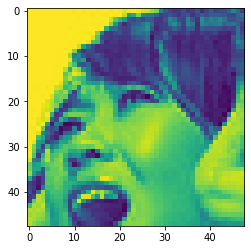

In [166]:
plt.imshow(single_image2)

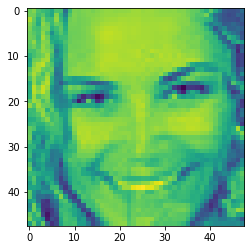

In [167]:
plt.imshow(single_image3)

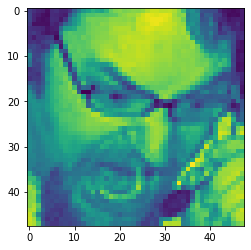

In [168]:
plt.imshow(single_image4)

In [158]:
single_image2 = np.expand_dims(single_image2, axis = 0)
single_image3 = np.expand_dims(single_image3, axis = 0)
single_image4 = np.expand_dims(single_image4, axis = 0)


single_image2 = np.expand_dims(single_image2, axis = -1)
single_image3 = np.expand_dims(single_image3, axis = -1)
single_image4 = np.expand_dims(single_image4, axis = -1)

In [159]:
single_image2.shape

(1, 48, 48, 1)

In [160]:
single_image2 = single_image2.astype('float16')
single_image3 = single_image3.astype('float16')
single_image4 = single_image4.astype('float16')

In [169]:
#predictions are angry, disgust, fear, happy, neutral, sad, surprise

In [161]:
model.predict(single_image2)

array([[0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [162]:
model.predict(single_image3)

array([[0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [163]:
model.predict(single_image4)

array([[0., 1., 0., 0., 0., 0., 0.]], dtype=float32)